In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from scipy.stats import pearsonr

In [2]:
gene_1=pd.read_csv('../data/raw/gene_1.txt',delimiter='\t', low_memory=False)

In [3]:
gene_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779 entries, 0 to 778
Columns: 1449 entries, Sample to Expression
dtypes: float64(1448), object(1)
memory usage: 8.6+ MB


In [4]:
gene_1.head()

,Sample,15-45976702-45977052,15-45982813-45983160,15-45983175-45983347,15-45995910-45996255,15-45996259-45996428,15-45996456-45996764,15-45996819-45996987,15-45997063-45997254,15-45997416-45997635,...,15-49315529-49315877,15-49381258-49381604,15-50167700-50167901,15-50315097-50315414,15-50347957-50348141,15-50479039-50479260,15-48103367-48103714,15-49414124-49414471,15-49938148-49938496,Expression
0,IHECRE00001955,0.49830,0.71765,1.26255,0.21368,0.85358,0.63976,0.33459,0.00000,0.44695,...,0.63570,2.50192,0.76997,0.48920,0.48993,0.78117,1.52976,1.38009,0.34980,0.0
1,IHECRE00000227,2.92223,2.66952,2.69382,0.72047,0.46327,0.04019,0.34007,0.14549,4.55700,...,0.07586,0.70405,0.80722,0.00000,0.29017,0.74775,2.92270,1.44552,2.42589,0.0
2,IHECRE00001478,0.43758,0.32964,1.62194,0.31023,1.32639,1.71436,1.44638,2.78841,2.27327,...,2.04935,1.37250,1.03671,1.56793,2.95682,0.28493,0.90301,0.52811,1.60139,0.0
3,IHECRE00002337,2.23747,2.68867,0.73725,1.34511,2.90871,1.64011,0.71892,0.08026,0.46206,...,0.96743,0.12732,0.51818,2.09059,2.24160,0.58484,1.78445,0.79445,1.14262,0.0
4,IHECRE00001236,0.32554,0.49021,0.72664,3.13590,1.32609,1.42868,2.00968,1.87176,2.91399,...,0.45535,0.65087,1.82249,0.02572,0.77713,0.83902,2.72411,0.73362,0.91528,0.0


## Conversion to TPM, Log2 transform and investigate effect on distribution

Data is in FPKM (insert source). We should convert to TPM because we learned that it's better. 

Additionally we will log2(x+1) transform, because apparently that's best practise to get closer to the assumption of normal distributedness needed for linear regression, etc., see for example https://montilab.github.io/BS831/articles/docs/RNAseq_ScalNorm.html

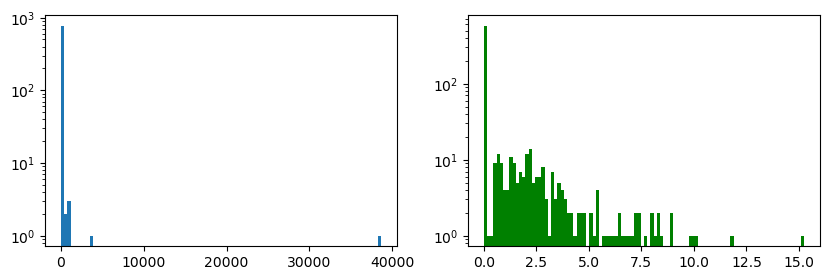

In [5]:
fig, axs=plt.subplots(1,2,figsize=(10,3))
axs[0].hist(gene_1['Expression'],bins=100)
axs[0].set_yscale('log')
axs[1].hist(np.log2(gene_1['Expression']+1), bins=100, color='g')
axs[1].set_yscale('log')
plt.show()

In [6]:
# log2 transform
gene_1['Expression']=np.log2(gene_1['Expression']+1)

In [7]:
X = gene_1.iloc[:,1:-1]
scaler = sk.preprocessing.StandardScaler()
X = scaler.fit_transform(X)
print(type(X))
corr=X.corr()
plt.imshow(corr, origin = 'lower')
plt.xlim(600,625)
plt.ylim(600,625)
plt.colorbar()

<class 'numpy.ndarray'>


AttributeError: 'numpy.ndarray' object has no attribute 'corr'

## Splitting into training and test data for further analysis

In [10]:
X_train, X_test, Y_train, Y_test, idx_train, idx_test = sk.model_selection.train_test_split(gene_1.iloc[:,0:-1], gene_1.iloc[:,-1], np.arange(len(gene_1['Expression'])), test_size=0.3)

In [11]:
# convert everything to numpy arrays 
X_train_np=X_train.iloc[:,1:].to_numpy()
X_test_np=X_test.iloc[:,1:].to_numpy()
Y_train_np=Y_train.to_numpy()
Y_test_np=Y_test.to_numpy()

In [12]:
# z-score data
x_scaler=sk.preprocessing.StandardScaler()
y_scaler=sk.preprocessing.StandardScaler()

In [13]:
X_train_np=x_scaler.fit_transform(X_train_np)
X_test_np=x_scaler.transform(X_test_np)
Y_train_np=y_scaler.fit_transform(Y_train_np.reshape(-1,1))[:,0]
Y_test_np=y_scaler.transform(Y_test_np.reshape(-1,1))[:,0]

## Principal component analysis

We do this to check two things:

- do samples cluster by expression or not
- can we obtain the same or even improved accuary by using PCA as a feature selection method

In [112]:
PCA=sk.decomposition.PCA()

In [113]:
X_trans=PCA.fit_transform(X_train_np)

In [ ]:
plt.scatter(X_trans[:,0], X_trans[:,1])

In [115]:
expl_var_ratio=PCA.explained_variance_ratio_

In [ ]:
plt.plot(expl_var_ratio)
plt.xlabel("n components")
plt.ylabel("explained variance")
#plt.xlim(0,100)

In [ ]:
print(expl_var_ratio[0:20])

Judging from this, it might be enough to keep only the first 20 principal components since the others explain less than 1% of variance.

In [191]:
X_pca=X_trans[:,0:20]

In [ ]:
exp_or_not=gene_1.iloc[idx_train,-1]
exp_or_not=exp_or_not>0
print(len(exp_or_not))

In [ ]:
plt.scatter(X_pca[:,0], X_pca[:,1],c=exp_or_not)
plt.xlabel('PC 1')
plt.ylabel('PC 2')

Conclusion: no visible clustering by whether the gene is expressed in a sample at all or not.

## 1 Baseline: Elastic net with all features

In [124]:
param_grid = {
 "alpha": [0.01, 0.1, 0.2, 0.5, 1],
 "l1_ratio": [0.5, 0.7, 0.9, 1.0]
}
elastic_net=sk.linear_model.ElasticNet(random_state=42, fit_intercept=False, max_iter=5000)
grid_searcher=sk.model_selection.GridSearchCV(elastic_net, param_grid, scoring='neg_root_mean_squared_error', refit=True, verbose=1)

In [ ]:
grid_searcher.fit(X_train_np, Y_train_np)

In [126]:
results=grid_searcher.cv_results_

In [127]:
df=pd.DataFrame(results)
df=df[['mean_fit_time', 'param_alpha', 'param_l1_ratio', 'mean_test_score', 'std_test_score', 'rank_test_score']]

In [ ]:
df.sort_values('rank_test_score', axis=0)

In [220]:
best_estimator=grid_searcher.best_estimator_

In [ ]:
# to see how many nonzero coefficients remain
print(np.sum(best_estimator.coef_!=0))
print(len(best_estimator.coef_))

In [130]:
Y_pred = best_estimator.predict(X_test_np)

In [ ]:
elastic_net_score=best_estimator.score(X_test_np, Y_test_np)
print(elastic_net_score)

In [132]:
MSE=sk.metrics.mean_squared_error(Y_test_np, Y_pred)

In [ ]:
print(MSE)

In [ ]:
plt.scatter(np.arange(len(Y_test_np)),Y_test_np, label='Y_test')
plt.scatter(np.arange(len(Y_pred)),Y_pred, label='Y_pred')
plt.xlabel('sample idx')

In [ ]:
plt.scatter(Y_test_np,Y_pred)
plt.xlabel('Y_test')
plt.ylabel('Y_pred')

In [ ]:
elastic_net_corr=pearsonr(Y_test_np, Y_pred)
print(elastic_net_corr)

## 2 Elastic net with first 20 PCs

In [194]:
elastic_net_2=sk.linear_model.ElasticNet(random_state=42, fit_intercept=False, max_iter=5000)
grid_searcher_2=sk.model_selection.GridSearchCV(elastic_net_2, param_grid, scoring='neg_root_mean_squared_error', refit=True, verbose=1)

In [ ]:
grid_searcher_2.fit(X_pca, Y_train_np)

In [196]:
best_estimator_2=grid_searcher_2.best_estimator_

In [197]:
results=grid_searcher_2.cv_results_

In [198]:
df=pd.DataFrame(results)
df=df[['mean_fit_time', 'param_alpha', 'param_l1_ratio', 'mean_test_score', 'std_test_score', 'rank_test_score']]

In [ ]:
df.sort_values('rank_test_score', axis=0)

In [200]:
X_test_pca=PCA.transform(X_test_np)
X_test_pca=X_test_pca[:,0:20]

In [201]:
Y_pred = best_estimator_2.predict(X_test_pca)

In [ ]:
elastic_net_score=best_estimator.score(X_test_np, Y_test_np)
print(elastic_net_score)

In [ ]:
MSE=sk.metrics.mean_squared_error(Y_test_np, Y_pred)
print(MSE)

In [ ]:
plt.scatter(np.arange(len(Y_test_np)),Y_test_np)
plt.scatter(np.arange(len(Y_pred)),Y_pred)

Conclusion: slightly worse performance keeping only the first 20 PCs but difference is so small that it might be worth investigating as a feature selection method for training with neural networks.

## Gradient boosting

In [205]:
gb_regressor=sk.ensemble.GradientBoostingRegressor()

In [ ]:
gb_regressor.fit(X_train_np, Y_train_np)

In [207]:
Y_pred=gb_regressor.predict(X_test_np)

In [ ]:
gb_score=gb_regressor.score(X_test_np,Y_test_np)
print(gb_score)

In [209]:
gb_MSE=sk.metrics.mean_squared_error(Y_test_np,Y_pred)

In [ ]:
print(gb_MSE)

In [211]:
from scipy.stats import pearsonr

In [ ]:
gb_corr=pearsonr(Y_test_np, Y_pred)
print(gb_corr)

In [ ]:
plt.scatter(Y_test_np,Y_pred)

Conclusion: gradient boosting does slighlty better than elastic net, definitely worth investigating in controlled experiments, other nonlinear/distribution-distribution free methods.

## Hyperparameter tuning on gradient boosting

In [222]:
param_grid = {
 "learning_rate": [0.05, 0.1, 0.2],
 "n_estimators": [100, 200],
 "max_depth": [1, 5, 10, 20, 50]
}
gb_regressor=sk.ensemble.GradientBoostingRegressor()
grid_searcher=sk.model_selection.GridSearchCV(gb_regressor, param_grid, scoring='neg_root_mean_squared_error', refit=True, verbose=1)

In [ ]:
'''
CAUTION, executing this cell took me 3 hours to finish, 
for best model, see txt file with parameters in results folder
'''

grid_searcher.fit(X_train_np, Y_train_np)

In [225]:
results=grid_searcher.cv_results_

In [229]:
df=pd.DataFrame(results)
df=df[['mean_fit_time', 'param_learning_rate', 'param_n_estimators', 'param_max_depth', 'mean_test_score', 'std_test_score', 'rank_test_score']]

In [ ]:
df.sort_values('rank_test_score', axis=0)

In [231]:
best_estimator=grid_searcher.best_estimator_

In [232]:
Y_pred=best_estimator.predict(X_test_np)

In [ ]:
score=best_estimator.score(X_test_np, Y_test_np)
print(score)

In [ ]:
MSE=sk.metrics.mean_squared_error(Y_pred, Y_test_np)
print(MSE)

In [ ]:
corr_coeff=pearsonr(Y_test_np,Y_pred)
print(corr_coeff)

In [ ]:
plt.scatter(Y_test_np,Y_pred)

In [ ]:
plt.scatter(np.arange(len(Y_test_np)),Y_test_np)
plt.scatter(np.arange(len(Y_pred)), Y_pred)

In [ ]:
df.to_csv('../results/gradient_boost_gridsearchcv.txt', sep='\t')

## K-means clustering

To see whether there are obvious clusters and it might be worth trying a mixture-of-experts-model

In [214]:
k_means=sk.cluster.KMeans(n_clusters=3)

In [215]:
clusters=k_means.fit_predict(Y_train_np.reshape(-1,1))

In [ ]:
plt.scatter(np.arange(len(Y_train_np)),Y_train_np,c=clusters)

In [217]:
from scipy.spatial.distance import cdist
distortions = []
inertias = []
mapping2 = {}
K = range(1, 10)

for k in K:
    kmeanModel = sk.cluster.KMeans(n_clusters=k, random_state=42).fit(Y_train_np.reshape(-1,1))  
    inertias.append(kmeanModel.inertia_)
    mapping2[k] = inertias[-1]

In [ ]:
print("Inertia values:")
for key, val in mapping2.items():
    print(f'{key} : {val}')

plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [52]:
gene_1=pd.read_csv('../data/raw/gene_1.txt',delimiter='\t', low_memory=False)